## Step 1: Define your AWS region and S3 bucket where you will store the data

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
region = session.boto_region_name

role = get_execution_role()  # Works inside SageMaker Studio
bucket = "knodax-ml-specialty-lab-exercises"  # e.g., "knodax-ml-labs"
prefix = "ml-lab-datasets/framing-business-problems-as-ml-problems/classification"

print("Region:", region)
print("Bucket:", bucket)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Bucket: knodax-ml-specialty-lab-exercises


## Step 2: Classification Model – Fraud Detection

You’ll now:
<ol>
  <li>Create a synthetic credit card transactions dataset (about 1,000 rows) based on the sample.</li>
  <li>Upload it to S3.</li>
  <li>Load the data in the notebook and preprocess it.</li>
  <li>Train a binary classification model (fraud vs. non-fraud).</li>
  <li>Evaluate using accuracy, precision, recall, and a confusion matrix.</li>
</ol>


### 2.1 Create a Synthetic Fraud Dataset (1,000 Records)

First, start from the small sample provided and expand it into a larger dataset.

In [2]:
import pandas as pd
import numpy as np

# ---- Base sample rows (from the prompt) ----
base_rows = [
    [100001,120.50,"13:45","New York","Electronics",0],
    [100002,8.99,"09:20","San Francisco","Coffee Shop",0],
    [100003,560.00,"02:10","Las Vegas","Jewelry",1],
    [100004,43.25,"17:50","Chicago","Grocery",0],
    [100005,3200.00,"03:30","Los Angeles","Luxury Goods",1],
    [100006,15.00,"11:05","Boston","Books",0],
    [100007,850.75,"01:45","Miami","Electronics",1],
    [100008,25.00,"14:30","Seattle","Clothing",0],
    [100009,199.99,"22:15","New York","Furniture",0],
    [100010,999.00,"04:00","Houston","Travel",1],
]

columns = ["TransactionID","Amount","Time","Location","MerchantCategory","IsFraud"]
base_df = pd.DataFrame(base_rows, columns=columns)
base_df


,TransactionID,Amount,Time,Location,MerchantCategory,IsFraud
0,100001,120.50,13:45,New York,Electronics,0
1,100002,8.99,09:20,San Francisco,Coffee Shop,0
2,100003,560.00,02:10,Las Vegas,Jewelry,1
3,100004,43.25,17:50,Chicago,Grocery,0
4,100005,3200.00,03:30,Los Angeles,Luxury Goods,1
5,100006,15.00,11:05,Boston,Books,0
6,100007,850.75,01:45,Miami,Electronics,1
7,100008,25.00,14:30,Seattle,Clothing,0
8,100009,199.99,22:15,New York,Furniture,0
9,100010,999.00,04:00,Houston,Travel,1


Now, generate around 1,000 synthetic rows using simple rules:
<ul>
<li>Higher amounts and late-night hours have a higher probability of being fraud.</li>
<li>Keep locations and merchant categories similar to the sample.</li>
</ul>


In [3]:
import random

locations = ["New York", "San Francisco", "Las Vegas", "Chicago", "Los Angeles",
             "Boston", "Miami", "Seattle", "Houston", "Dallas", "Atlanta", "Denver"]
merchant_categories = ["Electronics", "Coffee Shop", "Jewelry", "Grocery",
                       "Luxury Goods", "Books", "Clothing", "Furniture", "Travel", "Online Services"]

def random_time():
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    return f"{hour:02d}:{minute:02d}"

def generate_transaction(txn_id):
    amount = round(np.random.lognormal(mean=3.5, sigma=1.0), 2)  # skewed positive
    time_str = random_time()
    location = random.choice(locations)
    merchant = random.choice(merchant_categories)
    
    # Simple fraud logic: higher risk at night and with large amounts
    hour = int(time_str.split(":")[0])
    base_prob = 0.03                # 3% base fraud rate
    if amount > 500:
        base_prob += 0.10
    if hour < 6 or hour > 22:
        base_prob += 0.07
    is_fraud = 1 if random.random() < base_prob else 0
    
    return [txn_id, amount, time_str, location, merchant, is_fraud]

synthetic_rows = [generate_transaction(100000 + i) for i in range(1, 1001)]
df = pd.DataFrame(synthetic_rows, columns=columns)
df.head()
len(df)


1000

### 2.2 Save the Dataset Locally and Upload to S3

In [5]:
# Save to local CSV
local_path = "sample_credit_card_fraud.csv"
df.to_csv(local_path, index=False)

# Upload to S3
s3 = boto3.client("s3", region_name=region)
s3_key = f"{prefix}/sample_credit_card_fraud.csv"

s3.upload_file(local_path, bucket, s3_key)
print(f"Uploaded to s3://{bucket}/{s3_key}")


Uploaded to s3://knodax-ml-specialty-lab-exercises/ml-lab-datasets/framing-business-problems-as-ml-problems/classification/sample_credit_card_fraud.csv


### 2.3 Load the Dataset in the Notebook

(You can load directly from local, or from S3. Here we read from local for simplicity.)

In [7]:
data = pd.read_csv(local_path)
data.head()
data.describe(include="all")


,TransactionID,Amount,Time,Location,MerchantCategory,IsFraud
count,1000.000000,1000.000000,1000,1000,1000,1000.000000
unique,NaN,NaN,726,12,10,NaN
top,NaN,NaN,00:41,Denver,Luxury Goods,NaN
freq,NaN,NaN,5,97,118,NaN
mean,100500.500000,54.511850,NaN,NaN,NaN,0.062000
std,288.819436,61.400192,NaN,NaN,NaN,0.241276
min,100001.000000,0.940000,NaN,NaN,NaN,0.000000
25%,100250.750000,16.960000,NaN,NaN,NaN,0.000000
50%,100500.500000,34.735000,NaN,NaN,NaN,0.000000
75%,100750.250000,68.512500,NaN,NaN,NaN,0.000000


### 2.4 Feature Engineering and Preprocessing

We will:
<ul>
  <li>Extract hour from the <code>Time</code> column.</li>
  <li>Drop <code>TransactionID</code> and the string <code>Time</code> column.</li>
  <li>One-hot encode <code>Location</code> and <code>MerchantCategory</code>.</li>
  <li>Split into features (<code>X</code>) and label (<code>y</code>).</li>
</ul>


In [8]:
# Extract hour from Time
data["Hour"] = data["Time"].str.split(":").str[0].astype(int)

# Drop non-feature columns
data = data.drop(columns=["TransactionID", "Time"])

# Separate target
y = data["IsFraud"]
X = data.drop(columns=["IsFraud"])

# One-hot encode categorical columns
categorical_cols = ["Location", "MerchantCategory"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X.head(), y.head()


(   Amount  Hour  Location_Boston  Location_Chicago  Location_Dallas  \
 0   39.49     7            False             False            False   
 1   66.49    23             True             False            False   
 2  153.94    11            False             False            False   
 3   43.11     8            False              True            False   
 4   10.43     9            False             False            False   
 
    Location_Denver  Location_Houston  Location_Las Vegas  \
 0            False             False               False   
 1            False             False               False   
 2            False             False               False   
 3            False             False               False   
 4            False             False               False   
 
    Location_Los Angeles  Location_Miami  ...  Location_Seattle  \
 0                 False            True  ...             False   
 1                 False           False  ...             False 

### 2.5 Train–Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((800, 22), (200, 22))

### 2.6 Train a Classification Model (Random Forest Example)

You can use any classifier (Logistic Regression, XGBoost, etc.). Here’s a RandomForestClassifier using scikit-learn:

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"  # handle fraud imbalance if any
)

rf_clf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Evaluate Model – Accuracy, Precision, Recall

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

y_pred = rf_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Accuracy : 0.9400
Precision: 0.0000
Recall   : 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       188
           1       0.00      0.00      0.00        12

    accuracy                           0.94       200
   macro avg       0.47      0.50      0.48       200
weighted avg       0.88      0.94      0.91       200



<ul>
<li>Accuracy: overall fraction of correct predictions. </li>
<li>Precision (for class 1 = fraud): of all predicted frauds, how many were truly fraud. </li>
<li>Recall (for class 1): of all actual frauds, how many did we catch.</li>
</ul>

### 2.8 Visualize Results with a Confusion Matrix

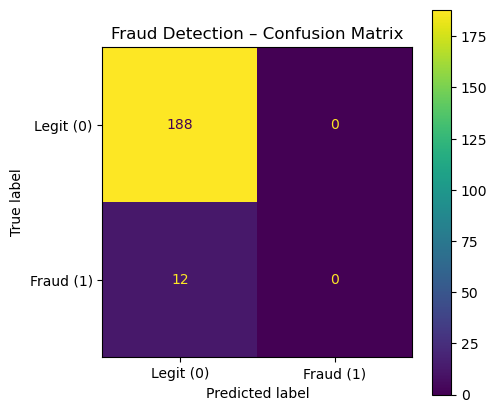

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit (0)", "Fraud (1)"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)
plt.title("Fraud Detection – Confusion Matrix")
plt.show()


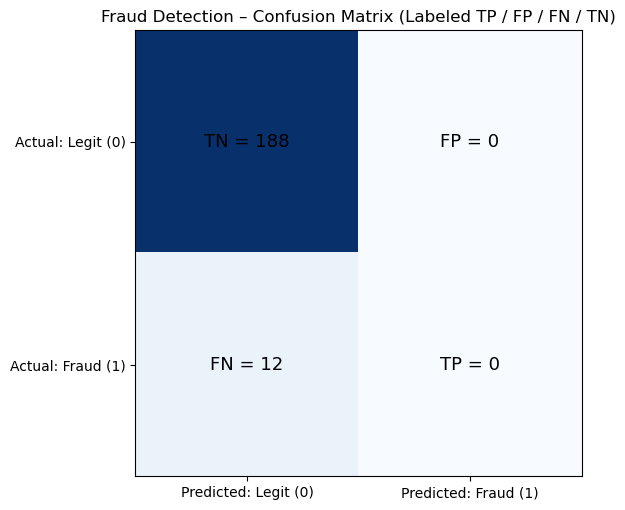

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Show matrix as image
ax.imshow(cm, cmap="Blues")

# Set axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Predicted: Legit (0)", "Predicted: Fraud (1)"])
ax.set_yticklabels(["Actual: Legit (0)", "Actual: Fraud (1)"])

# Annotate each cell with value + label
labels = np.array([
    [f"TN = {tn}", f"FP = {fp}"],
    [f"FN = {fn}", f"TP = {tp}"]
])

for i in range(2):
    for j in range(2):
        ax.text(j, i, labels[i, j],
                ha="center", va="center", fontsize=13, color="black")

plt.title("Fraud Detection – Confusion Matrix (Labeled TP / FP / FN / TN)")
plt.tight_layout()
plt.show()


## What This Plot Shows
|                      | **Predicted Legit (0)** | **Predicted Fraud (1)** |
| -------------------- | ----------------------- | ----------------------- |
| **Actual Legit (0)** | TN (True Negative)      | FP (False Positive)     |
| **Actual Fraud (1)** | FN (False Negative)     | TP (True Positive)      |


## How This Maps to Confusion Matrix Terms
| Confusion Matrix Term   | Meaning in Fraud Context                                     |
| ----------------------- | ------------------------------------------------------------ |
| **TP (True Positive)**  | Model correctly predicts **fraud**                           |
| **FP (False Positive)** | Model incorrectly predicts fraud for a **legit** transaction |
| **TN (True Negative)**  | Model correctly predicts **legit** (no fraud)                |
| **FN (False Negative)** | Model fails to detect a fraud → predicts **legit**           |
ArithmeticError

## Why FN (False Negatives) Are the Most Dangerous

False Negative = transaction is fraud, but model says it’s legit
These lead to financial loss because fraud goes undetected.

In real fraud systems:
Recall (catching frauds) is often weighted more heavily than precision.
It’s often safer to review more flagged transactions (FP) than to miss real frauds (FN).

## Final Summary
<ul>
<li>Negative = No Fraud. Positive = Fraud.</li>
<li>True Negative = correctly identified legit transaction.</li>
<li>True Positive = correctly identified fraud.</li>
</ul>

### 2.9 (Optional) Inspect Feature Importance


In [14]:
import numpy as np

feature_importances = pd.Series(
    rf_clf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importances.head(15)


Hour                                0.288665
Amount                              0.272748
Location_Miami                      0.030136
MerchantCategory_Grocery            0.028994
Location_Los Angeles                0.028817
MerchantCategory_Furniture          0.028511
Location_New York                   0.026390
MerchantCategory_Electronics        0.025507
Location_San Francisco              0.024497
MerchantCategory_Clothing           0.024306
MerchantCategory_Luxury Goods       0.021385
MerchantCategory_Jewelry            0.020321
MerchantCategory_Online Services    0.019325
MerchantCategory_Coffee Shop        0.018932
MerchantCategory_Travel             0.018849
dtype: float64

This helps to see which features (e.g., Amount, Hour, specific locations or merchant categories) contribute most to fraud predictions. A higher number means the feature contributes more to the model’s decision.

## Summary

By completing the steps above, you have:
<ul>
  <li>Created and uploaded a fraud dataset to Amazon S3.</li>
  <li>Preprocessed numeric and categorical features.</li>
  <li>Trained a binary classification model in SageMaker Studio.</li>
  <li>Evaluated it using accuracy, precision, recall, and a confusion matrix.</li>
</ul>

